In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
import json

In [3]:
# Helper function from Ching's code
def create_grids(img_shape, grid_size):
    x = np.linspace(0, img_shape[1], grid_size + 2, dtype=np.float32)[1:-1]
    y = np.linspace(0, img_shape[0], grid_size + 2, dtype=np.float32)[1:-1]
    xx, yy = np.meshgrid(x, y)
    p_grid = np.concatenate((yy.reshape(-1, 1), xx.reshape(-1, 1)), axis=1) #ORDER CHANGED WITH RESPECT TO CHING'S CODE
    return p_grid

## First we load a example optical flow

In [5]:
of = np.load("/users/tom/experiments/neon_blink_detection/datasets/train_data/optical_flow/step7-win7-steps3-shape64/1004-2022-12-14-13-14-14-c8a509b9.npz")
# ['feature_array', 'clip_transitions', 'timestamps']

section_idxs = []
section_start = 0
if of['clip_transitions']:
    for transition in of['clip_transitions']:
        section_end = transition
        section_idxs.append([section_start, section_end])
        section_start = section_end + 1
section_idxs.append([section_start,-1])


sections = [{'feature_array': of['feature_array'][clip_start:clip_end], 'timestamps': of['timestamps'][clip_start:clip_end]} for clip_start, clip_end in section_idxs]

## Now, we will define interpolating functions, which will be interpolators of the whole left and right optical flow, respectively

In [6]:
n = 1 # Which section to use

In [7]:
of_left = np.reshape(sections[n]['feature_array'][:,:400,1],(-1,20,20))
of_right = np.reshape(sections[n]['feature_array'][:,400:,1],(-1,20,20))

print(of_left.shape)

(13482, 20, 20)


In [8]:
t = np.asarray(sections[n]['timestamps'], dtype=np.float64)
t0 = t[0] # Needef for later normalization)
t = (t-t[0])/1e9

x = np.linspace(0, 64, 20 + 2, dtype=np.float32)[1:-1]
y = np.linspace(0, 64, 20 + 2, dtype=np.float32)[1:-1]

interpolator_left = RegularGridInterpolator((t,x,y), of_left, bounds_error=False, fill_value=None, method='linear')
interpolator_right = RegularGridInterpolator((t,x,y), of_right, bounds_error=False, fill_value=None, method='linear')

(225, 2)

## Let's interpolate the optical flow of a specific frame

In [9]:
frame = 290 # Which frame to use

In [10]:
grid_size = 500 # grid_size we want to interpolate to
p_grid = create_grids((64,64), grid_size)
time_ = t[frame] # timestamp belonging to the frame
t_p_grid  = np.concatenate((time_ * np.ones((p_grid.shape[0],1)), p_grid), axis=1) 
of_interp = np.reshape(interpolator_left(t_p_grid),(grid_size, grid_size))


(13482,)

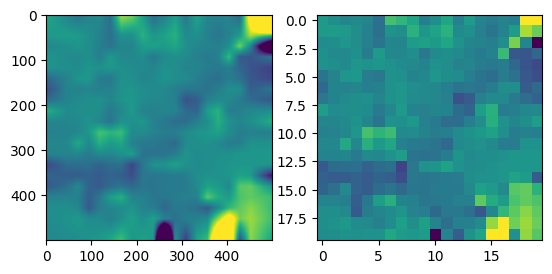

In [11]:
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(of_interp,vmin=-2, vmax=2)
ax[1].imshow(of_left[frame],vmin=-2, vmax=2)

## Next, we check whether can recuperate the original optical flow from the interpolating functions as expected

In [12]:
def grid_points(t,x,y): # This is an array of all points for which there is of
    temp = np.meshgrid(t, x, y, indexing='ij')
    return np.concatenate([np.ravel(entry)[:,np.newaxis] for entry in temp], axis=1)

In [13]:
t_p_grid_orig = grid_points(t,x,y) 
of_left_reconst = np.reshape(interpolator_left(t_p_grid_orig), of_left.shape)
np.allclose(of_left_reconst-of_left, 0)

True

## Now we look at an example blink and how by dilating time, we can speed it up or slow it down

In [14]:
def get_start_end(event):
    return [(event['start_ts']-t0)/1e9,(event['end_ts']-t0)/1e9] 

blinks_dict = json.load(open("/cluster/users/tom/experiments/neon_blink_detection/datasets/train_data/1004-2022-12-14-13-14-14-c8a509b9/annotations-1004-2022-12-14-13-14-14-c8a509b9.json","r"))
blinks = []
blink_started = False
for key in blinks_dict.keys():
    current_key = key
    current_label = blinks_dict[current_key]['label']
    if current_label=='A' and blink_started==False and blinks_dict[current_key]['start_ts']>t[0]:
        blinks.append([(blinks_dict[current_key]['start_ts']-t0)/1e9])
        blink_started = True
    if current_label=='B' and  blink_started == True:
        blinks[-1].append((blinks_dict[current_key]['end_ts']-t0)/1e9)
        blink_started = False

onsets = [get_start_end(blinks_dict[key]) for key in blinks_dict.keys() if blinks_dict[key]['label']=='A']
offsets = [get_start_end(blinks_dict[key]) for key in blinks_dict.keys() if blinks_dict[key]['label']=='B']

FileNotFoundError: [Errno 2] No such file or directory: '/cluster/users/tom/experiments/neon_blink_detection/datasets/train_data/1004-2022-12-14-13-14-14-c8a509b9/annotations-1004-2022-12-14-13-14-14-c8a509b9.json'

In [15]:
for blink in blinks:
    if blink[0]>t[0]:
        plt.plot(blink, [80,80], "g", lw=3)
for onset in onsets:
    if onset[0]>t[0]:
        plt.plot(onset, [85,85], "r", lw=3)
for offset in offsets:
    if offset[0]>t[0]:
        plt.plot(offset, [85,85], "b", lw=3)
    
    
for i in range(20):
    for j in range(20):
        plt.plot(t, of_left[:,i,j], 'b', alpha=0.01)
plt.ylim(-100,100)
plt.xlim(t[1800],t[2000])

NameError: name 'blinks' is not defined

In [16]:
def get_augmentation_pars():
    
    std_speed = 0.2
    std_translation = 3
    std_scale = 0.15
    std_linear = 0.03
    
    speed = np.random.normal(1, std_speed)
    translation = np.random.normal(0, std_translation, 2)
    scale = np.random.normal(1, std_scale)
    linear_distort = np.eye(2) + np.random.normal(0, std_linear, (2,2))
    
    return speed, translation, scale, linear_distort

In [17]:
grid_size = 4 # size of the grid we want to augment to

(-5.0, 70.0)

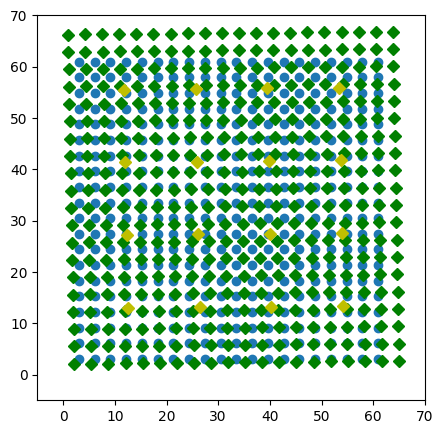

In [19]:
speed, translation, scale, linear_distort = get_augmentation_pars()

p_grid = create_grids((64,64), grid_size) 
p_grid_trans = np.empty_like(p_grid)

p_grid_trans = (linear_distort @ (scale * (p_grid - 32.)).T).T + 32 + translation

p_grid = create_grids((64,64), 20) 
p_grid_trans_lg = (linear_distort @ (scale * (p_grid - 32.)).T).T + 32 + translation

fig = plt.figure(figsize=(5,5))
plt.plot(p_grid[:,0], p_grid[:,1],'o')
plt.plot(p_grid_trans_lg[:,0], p_grid_trans_lg[:,1],'gD')
plt.plot(p_grid_trans[:,0], p_grid_trans[:,1],'yD')

plt.xlim(-5, 70)
plt.ylim(-5, 70)

In [24]:
t[0] + 1*(t_p_grid[:,0]-t[0])


array([1.45637504, 1.45637504, 1.45637504, ..., 1.45637504, 1.45637504,
       1.45637504])

In [25]:
speed, translation, scale, linear_distort = get_augmentation_pars()
speed = 1.2
x_of = np.linspace(0, 64, 20 + 2, dtype=np.float32)[1:-1]
y_of = np.linspace(0, 64, 20 + 2, dtype=np.float32)[1:-1]

t_p_grid = grid_points(t, x_of, y_of)  

t_p_grid_trans = np.zeros_like(t_p_grid)
t_p_grid_trans[:,1:] = (linear_distort @ (scale * (t_p_grid[:,1:] - 32.)).T).T + 32 + translation
t_p_grid_trans[:,0] = t[0] + speed * (t_p_grid[:,0]-t[0])

t_trans = t[0] + speed * (t - t[0])

of_trans = np.reshape( 1. / speed * interpolator_left(t_p_grid_trans), (len(t), len(x_of), len(y_of)))


array([[[1., 1., 1.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [1., 1., 1.]]])

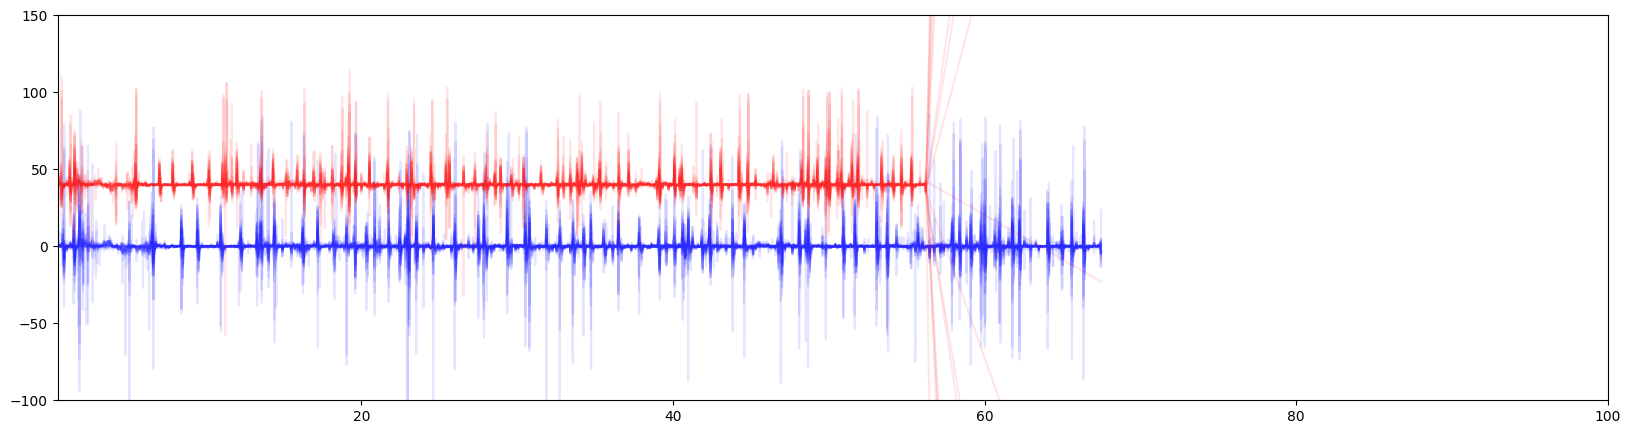

In [64]:
fig, ax = plt.subplots(ncols=1, figsize=(20,5))

for i in range(4,20,4): 
    for j in range(4,20,4):
        ax.plot(t, of_left[:,i,j], 'b', alpha=0.1)
for i in range(4,20,4):
    for j in range(4,20,4):
        ax.plot(t, of_trans[:,i,j]+40, 'r', alpha=0.1)
        
min_, max_ = ax.get_xlim()
for a_ in [ax]:
    a_.set_ylim(-100,150)
    a_.set_xlim(0.5,100)


Why window 7?
Are you testing on normally generated optical flow?
Why are blinks so long? 



In [52]:
speed

0.7878806184602678

In [12]:
import numpy as np
import sys
sys.path.append("/cluster/users/tom/git/neon_blink_detection/")

from training.video_loader import video_loader
from src.helper import OfParams, AugParams
from pathlib import Path

video_path = Path("/cluster/users/tom/experiments/neon_blink_detection/datasets/train_data")
of_path = Path("/cluster/users/tom/experiments/neon_blink_detection/datasets/train_data/optical_flow")

of_params = OfParams()
aug_params = AugParams()

clip_names = np.array(
    [

        "2023-02-01_11-45-11-7621531e",
    ]
)


/cluster/anaconda3/envs/tom_py310/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
of_params = OfParams(n_layers=3, layer_interval=7, average=False, img_shape=(64, 64), grid_size=4, step_size=5, window_size=15, stop_steps=3)

rec = video_loader(of_params, aug_params)


In [20]:
rec._load(clip_name=clip_names[0], bg_ratio=3, augment=False)

In [23]:
rec.all_features["2023-02-01_11-45-11-7621531e"].shape

(37234, 96)

In [31]:
np.concatenate(6*[create_grids((64,64), 6, False)])

(96, 2)

In [26]:
import typing as T
def create_grids(
    img_shape: T.Tuple[int, int], grid_size: int, full_grid: bool
) -> np.ndarray:
    x = np.linspace(0, img_shape[1], grid_size, dtype=np.float32)
    y = np.linspace(0, img_shape[0], grid_size, dtype=np.float32)
    xx, yy = np.meshgrid(x, y)
    p_grid = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)

    if not full_grid:
        p_grid = p_grid[np.all((p_grid != 0) & (p_grid != img_shape[0]), axis=1), :]

    return p_grid
